In [1]:
import numpy as np
from typing import Iterable
from CoolProp.CoolProp import PropsSI
from matplotlib import pyplot as plt

In [2]:
def lmtd(th: Iterable[float], tc: Iterable[float]) -> float:
    return ((th[0] - tc[1]) - (th[1] - tc[0])) / np.log(
        (th[0] - tc[1]) / (th[1] - tc[0])
    )

def diff(th: Iterable[float], tc: Iterable[float]): 
    return  (th[1] - th[0]) - (tc[1] - tc[0])

In [3]:
temp_co2 = np.linspace(89, 26, 100)
temp_air = np.linspace(25, 88, 100) 
y = [lmtd((89, t), (25, 80)) for t in temp_co2]
y2 =  [diff((89, t), (25, 80)) for t in temp_co2] 

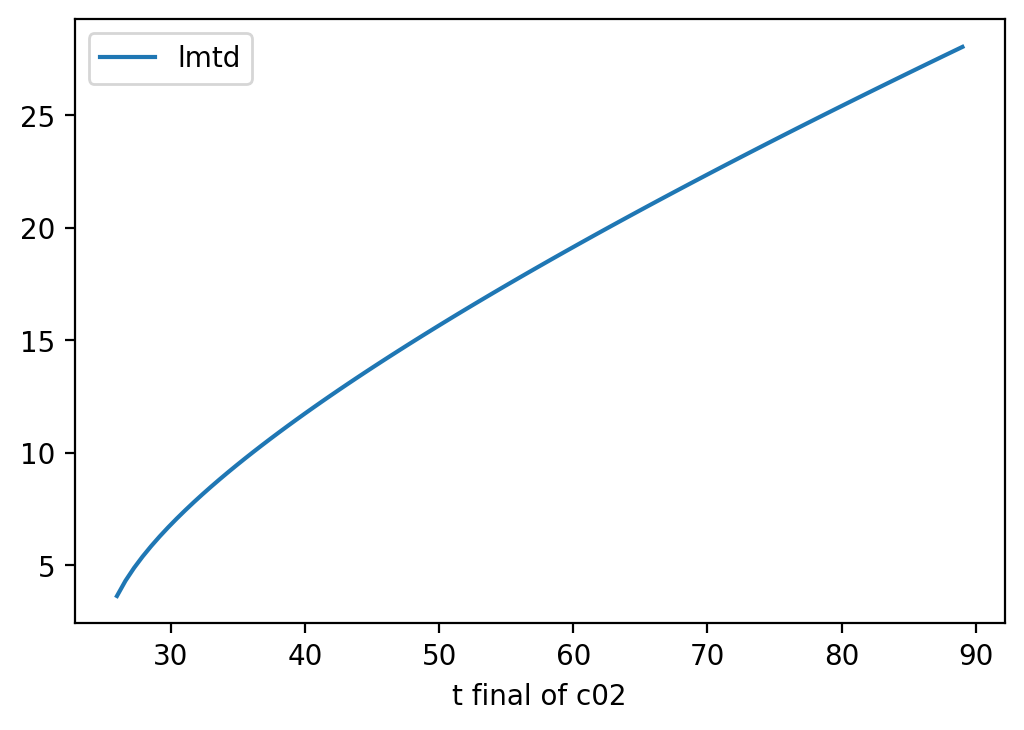

In [63]:
ax, fig = plt.subplots(1,1, dpi=200)
plt.plot(temp_co2, y, label="lmtd")
# plt.plot(temp_co2, y2, label="difference")
plt.xlabel("t final of c02")
plt.legend()
plt.show()

/tmp/ipykernel_99859/3811428902.py:2: RuntimeWarning: invalid value encountered in double_scalars
  return ((th[0] - tc[1]) - (th[1] - tc[0])) / np.log(


Text(0.5, 1.0, '$\\Delta T_m$')

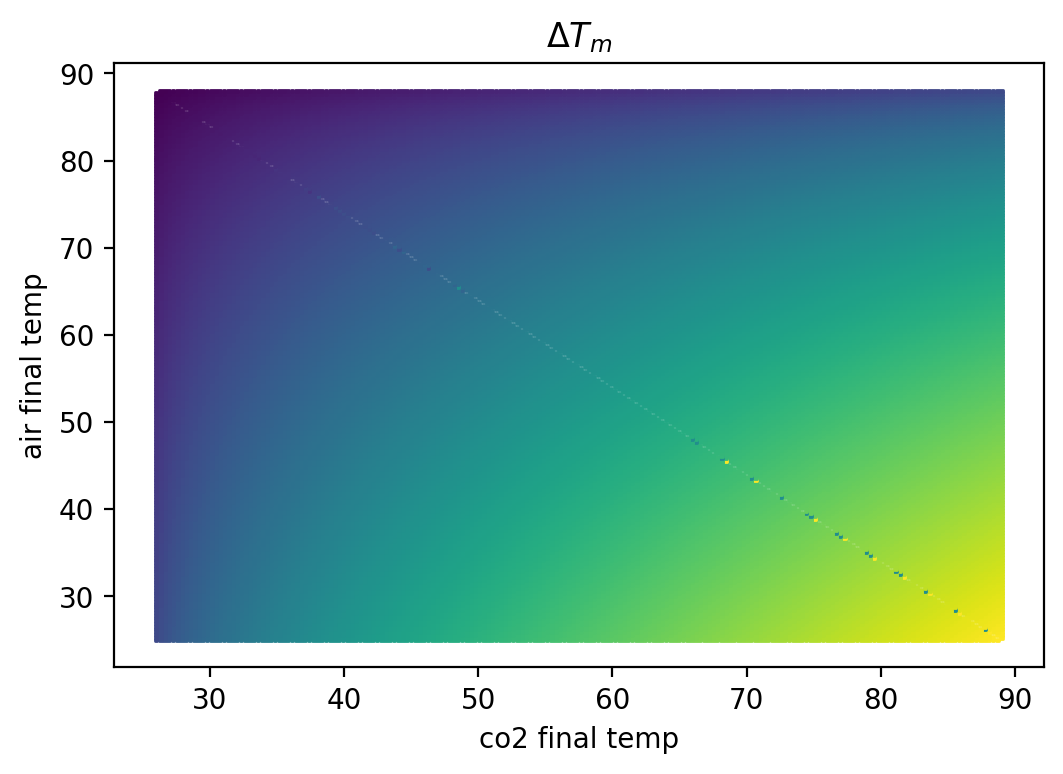

In [74]:
from itertools import product
plt.figure(dpi=200)
temp_co2 = np.linspace(89, 26, 200)
temp_air = np.linspace(25, 88, 200) 
temp_pairs = np.array(list(product(temp_co2, temp_air)))
y = [lmtd((89, t), (25, t2)) for t, t2 in temp_pairs]
plt.scatter(*temp_pairs.T, c = y, s=1, marker='s')
plt.xlabel("co2 final temp")
plt.ylabel("air final temp")
plt.title(r"$\Delta T_m$")

In [4]:
# Designing for 100 MW

def get_enthalpy(p : Iterable[float], t: Iterable[float], fluid : str = "CO2") -> Iterable[float]: 
    """Compute the enthalpy of a fluid at a given pressure and temperature.

    Args:
        p (Iterable[float]): Iterable containing the pressures of the fluid in Pa.
        t (Iterable[float]): Iterable containing the temperatures of the fluid in Kelvin.
        fluid (str, optional): Fluid to use. Defaults to "CO2".

    Returns:
        Iterable[float]: Iterable containing the enthalpy of the fluid at the given temperature and pressures in J/kg.
    """
    enthalpies = PropsSI('H', 'P', p, 'T', t, fluid)
    return enthalpies


def compute_air_flow_rate():
    pass
    
class constants:
    t_co2_inlet = 89 + 273.15
    t_co2_outlet = 35 + 273.15
    t_air_inlet = 25  + 273.15
    p_co2_inlet = 8e6
    p_co2_outlet = 7.48e6

    # calculate air mass flow rate
    # WRITE m_CO2 calculation
    m_CO2 = 950  # [kg/s] for 100MW
    cp_air = 1.005  # [kJ/kg-K]

    # calculate total Q exchanged
    # NEED ENTHALPY OF CO2
    h_co2_inlet = get_enthalpy(p_co2_inlet, t_co2_inlet)
    h_co2_outlet = get_enthalpy(p_co2_outlet, t_co2_outlet)
    total_heat_transferred = abs(m_CO2 * (h_co2_outlet - h_co2_inlet))

    # find air mass flow rate
    t_air_outlet = 80 + 273.15 # guess outlet air T, cannot be higher than T_CO2_in
    delta_t_air = t_air_outlet - t_air_inlet
    m_air = total_heat_transferred / (
        cp_air * delta_t_air
    )  # Assuming something between 6.75 and 30 kg/s which correlates to about 2-5 m/s air velocity
     
    
    OHTC = 700 # [W/m2-K]


def lmtd(t_air_in: float, t_air_out:float, t_co2_in:float, t_co2_out:float) -> float:
    """ " Compute the LMTD for a given set of temperatures.

    Args:
        th (Iterable[float]): Iterable containing the initial and final temperatures of the hot fluid.
        tc (Iterable[float]): Iterable containing the initial and final temperatures of the cold fluid.

    Returns:
        float: The log mean temperature difference.
    """
    return ((t_co2_in - t_air_out) - (t_co2_out - t_air_in)) / np.log(
        (t_co2_in - t_air_out) / (t_co2_out - t_air_in)
    )


def energy_transferred(htc: float, th: Iterable[float], tc: Iterable[float]) -> float:
    """Compute the energy transferred between the hot and cold fluids.

    Args:
        htc (float): Heat transfer coefficient for the current iteration.
        th (Iterable[float]): Iterable containing the initial and final temperatures of the hot fluid.
        tc (Iterable[float]): Iterable containing the initial and final temperatures of the cold fluid.

    Returns:
        float: The energy transferred between the hot and cold fluids.
    """
    return htc * lmtd(th, tc)


def energy_co2(p_in: float, p_out: float, t_in: float, t_out: float) -> float:
    """Compute the energy transferred out of the sCO2.

    Args:
        p_in (float): Initial pressure of the sCO2.
        p_out (float): Final pressure of the sCO2.
        t_in (float): Initial temperature of the sCO2.
        t_out (float): Final temperature of the sCO2.

    Returns:
        float: The energy transferred out of the sCO2.
    """    
    h_in = get_enthalpy(p_in, t_in)
    h_out = get_enthalpy(p_out, t_out)
    return constants.m_CO2 * abs(h_out - h_in)


def energy_air(mdot: float, t0: float, t1: float) -> float:
    """Compute the energy transferred into the air.

    Args:
        mdot (float): Mass flow rate of the air.
        t0 (float): Temperature of the inlet air.
        t1 (float): Temperature of the outlet air.

    Returns:
        float: The energy transferred into the air.
    """
    return constants.cp_air * mdot * (t1 - t0)


def drop_pressure(p_in: float) -> float:
    """Compute the pressure drop of the sCO2 across an element and returns the outlet pressure.

    Args:
        p_in (_type_): Initial pressure of the sCO2.

    Returns:
        float: The output pressure of the sCO2.
    """
    # TODO figure out constants
    rho = 1
    f = 0.112  # from Eq. 16
    u = 1
    L = 1
    d = 1
    delta_p = (rho * f * u**2 * L) / (2 * d)
    p_out = p_in - delta_p
    return p_in # TODO figure out how to compute pressure drop

In [9]:
def temperature_iteration(p_co2_in, t_co2_in, t_air_in, max_depth=20):
    def binary_search_temps(left, right, max_depth):
        if max_depth == 0:
            raise RecursionError("Max depth reached")
        t_co2_out = (left + right) / 2
        p_co2_out = drop_pressure(p_co2_in)
        q_co2 = energy_co2(p_co2_in, p_co2_out, t_co2_in, t_co2_out)
        # TODO get m_air for segment
        m_air_segment = constants.m_air * 100 # number of segments  TODO check division of m_air by number of segments
        t_air_out = q_co2 / (m_air_segment * constants.cp_air) + t_air_in
        if t_air_out > t_co2_in:
            print(f"q_co2: {q_co2}")
            print(f"t_air_in: {t_air_in}, t_air_out: {t_air_out:.2f}, t_co2_out: {t_co2_out:.2f}, t_co2_in: {t_co2_in:.2f}, p_co2_in: {p_co2_in:.2f}, p_co2_out: {p_co2_out:.2f}")
            raise Exception("Air temperature is too high. Physics is broken") 

        delta_T_m = lmtd(t_air_in, t_air_out, t_co2_in, t_co2_out)
        q_htc = constants.OHTC * (delta_T_m)  # TODO OHTC may not be constant?
        print(f"tco2_out: {t_co2_out:.2f}, qco2: {q_co2:.2f}, qhtc: {q_htc:.2f}")
        if abs((q_htc - q_co2) / q_co2) > 0.01:
            # TODO change update rule
            if q_htc > q_co2: # too much heat change -> make temp lower
                right = t_co2_out
            else:
                left = t_co2_out
            return binary_search_temps(left, right, max_depth - 1)
        else:
            return t_co2_out, t_air_out

    # iterate until temperature converges.
    t_co2_out, t_air_out = binary_search_temps(t_air_in, t_co2_in, max_depth)
    return t_co2_out, t_air_out

In [10]:
temperature_iteration(constants.p_co2_outlet, constants.t_co2_outlet, constants.t_air_inlet)

tco2_out: 303.15, qco2: 101221999.62, qhtc: 4892.75
tco2_out: 305.65, qco2: 20776056.26, qhtc: 6046.92
tco2_out: 306.90, qco2: 8099997.52, qhtc: 6537.96
tco2_out: 307.52, qco2: 3734892.97, qhtc: 6771.92
tco2_out: 307.84, qco2: 1803364.56, qhtc: 6886.64
tco2_out: 307.99, qco2: 887052.61, qhtc: 6943.48
tco2_out: 308.07, qco2: 440022.53, qhtc: 6971.78
tco2_out: 308.11, qco2: 219153.43, qhtc: 6985.90
tco2_out: 308.13, qco2: 109364.46, qhtc: 6992.95
tco2_out: 308.14, qco2: 54629.44, qhtc: 6996.48
tco2_out: 308.15, qco2: 27301.55, qhtc: 6998.24
tco2_out: 308.15, qco2: 13647.49, qhtc: 6999.12
tco2_out: 308.15, qco2: 6822.92, qhtc: 6999.56
tco2_out: 308.15, qco2: 10235.00, qhtc: 6999.34
tco2_out: 308.15, qco2: 8528.91, qhtc: 6999.45
tco2_out: 308.15, qco2: 7675.90, qhtc: 6999.50
tco2_out: 308.15, qco2: 7249.41, qhtc: 6999.53
tco2_out: 308.15, qco2: 7036.17, qhtc: 6999.55


(308.1487411499023, 298.15003837889566)

In [8]:
temperature_iteration(constants.p_co2_outlet, constants.t_co2_outlet, constants.t_air_inlet)

tco2_out: 303.15, qco2: 101221999.62, qhtc: 4892.75
tco2_out: 305.65, qco2: 20776056.26, qhtc: 6046.92
tco2_out: 306.90, qco2: 8099997.52, qhtc: 6537.96
tco2_out: 307.52, qco2: 3734892.97, qhtc: 6771.92
tco2_out: 307.84, qco2: 1803364.56, qhtc: 6886.64
tco2_out: 307.99, qco2: 887052.61, qhtc: 6943.48
tco2_out: 308.07, qco2: 440022.53, qhtc: 6971.78
tco2_out: 308.11, qco2: 219153.43, qhtc: 6985.90
tco2_out: 308.13, qco2: 109364.46, qhtc: 6992.95
tco2_out: 308.14, qco2: 54629.44, qhtc: 6996.48
tco2_out: 308.15, qco2: 27301.55, qhtc: 6998.24
tco2_out: 308.15, qco2: 13647.49, qhtc: 6999.12
tco2_out: 308.15, qco2: 6822.92, qhtc: 6999.56


(308.148779296875, 298.15003721575886)

Text(0, 0.5, 'Enthalpy J/kg')

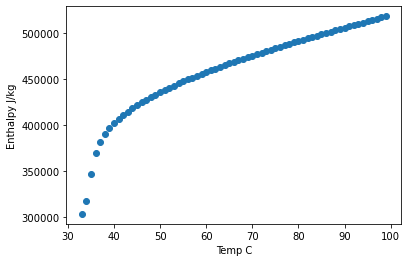

In [12]:
t =  np.arange(33, 100)
plt.scatter(t, PropsSI('H', 'P', 8e6, 'T', t + 273, "CO2"))
plt.xlabel("Temp C")
plt.ylabel("Enthalpy J/kg")
